### Import Packages

In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import datetime
import lightgbm as lgbm
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import os
        
RANDOM_SEED = 42

### Load files
* All the files used are as per below
> * fastest_routes_ files 
>> * Provides the shortest path from pickup point to dropoff point. 
>> * This file is from https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
> * train/test pickup/dropoff files 
>> * Provides the city and county information from the pickup and dropoff points. 
>> * This file is created by myself with New York shapefiles from https://www.kaggle.com/jackcook/neighborhoods-in-new-york
> * Weather files 
>> * Provides the hourly weather of New York. This file is from https://www.kaggle.com/selfishgene/historical-hourly-weather-data

In [2]:
train_df = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/train.zip', compression='zip')
test_df = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/test.zip', compression='zip') 
train_fastroute_df = pd.concat((pd.read_csv('/kaggle/input/osrm-oscarleo/fastest_routes_train_part_1.csv'), pd.read_csv('/kaggle/input/osrm-oscarleo/fastest_routes_train_part_2.csv')), axis = 0).reset_index(drop = True)
test_fastroute_df= pd.read_csv('/kaggle/input/osrm-oscarleo/fastest_routes_test.csv')
ny_shape_df = gpd.read_file('/kaggle/input/neighborhoods-in-new-york/ZillowNeighborhoods-NY.shp')
remain_train_pickup_df = pd.concat((pd.read_csv('/kaggle/input/nyc-tax-train-test-remain-2/train_city_pickup.csv'), pd.read_csv('/kaggle/input/nyc-tax-train-test-remain/train_city_pickup.csv')), axis = 0)
remain_train_dropoff_df = pd.concat((pd.read_csv('/kaggle/input/nyc-tax-train-test-remain-2/train_city_dropoff.csv'), pd.read_csv('/kaggle/input/nyc-tax-train-test-remain/train_city_dropoff.csv')), axis = 0)
remain_test_pickup_df = pd.concat((pd.read_csv('/kaggle/input/nyc-tax-train-test-remain-2/test_city_pickup.csv'), pd.read_csv('/kaggle/input/nyc-tax-train-test-remain/test_city_pickup.csv')), axis = 0)
remain_test_dropoff_df = pd.concat((pd.read_csv('/kaggle/input/nyc-tax-train-test-remain-2/test_city_dropoff.csv'), pd.read_csv('/kaggle/input/nyc-tax-train-test-remain/test_city_dropoff.csv')), axis = 0)

temperature_df = pd.read_csv('/kaggle/input/historical-hourly-weather-data/temperature.csv')
humidity_df = pd.read_csv('/kaggle/input/historical-hourly-weather-data/humidity.csv')
wind_speed_df = pd.read_csv('/kaggle/input/historical-hourly-weather-data/wind_speed.csv')
wind_direction_df = pd.read_csv('/kaggle/input/historical-hourly-weather-data/wind_direction.csv')

gc.collect()

21

### Functions and Utility Functions

In [3]:
def add_df_date_hour(df, string):
    """ 
    Utility function to add 'pickup_date' amd 'pickup_hour' for weather data.
    """
    
    df['pickup_date'] =  pd.to_datetime(df['datetime']).dt.date
    df['pickup_hour'] = pd.to_datetime(df['datetime']).dt.hour
    return df[['pickup_date', 'pickup_hour', 'New York']].rename(columns = {'New York' : string})

def get_haversine_distance(lat_1, long_1, lat_2, long_2):
    """
    Calculate the distance of 2 points with consideration of the roundness of earth.
    """
    
    AVG_EARTH_RADIUS = 6371
    lat_1, long1, lat_2, long_2 = map(np.radians, (lat_1, long_1, lat_2, long_2))
    lat = lat_2 - lat_1 ; long = long_2 - long_1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat_1) * np.cos(lat_2) * np.sin(long * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_direction(lat_1, long_1, lat_2, long_2):
    """
    Calculates the angle or direction of 2 points with consideration of the roundness of earth.
    """
    
    AVG_EARTH_RADIUS = 6371  # in km
    long_delta_rad = np.radians(long_2 - long_1)
    lat_1, long_1, lat_2, long_2 = map(np.radians, (lat_1, long_1, lat_2, long_2))
    y = np.sin(long_delta_rad) * np.cos(lat_2)
    x = np.cos(lat_1) * np.sin(lat_2) - np.sin(lat_1) * np.cos(lat_2) * np.cos(long_delta_rad)
    
    return np.degrees(np.arctan2(y, x))

def map_dic_to_dic(dic_1, dic_2):
    """
    Util function to map dictionary to dictionary
    """
    
    return {k : dic_2[v] for k, v in dic_1.items() if v in dic_2.keys()}

def merge_location_df(df, fastroute_df, pickup_df, dropoff_df):
    """
    Utility function to merge fastroute df and city/county information from pickup and dropoff points.
    """
    
    df = df.merge(fastroute_df, on = 'id')
    df = df.merge(pickup_df[['id', 'pickup_city']], on = 'id', how = 'left')
    df = df.merge(dropoff_df[['id', 'dropoff_city']], on = 'id', how = 'left')
    
    return df

def merge_weather_df(df, temp_df, hum_df, ws_df, wd_df):
    """
    Utilty function to merge weather dataframes.
    """
    
    df = df.merge(temp_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(hum_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(ws_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    df = df.merge(wd_df, on = ['pickup_date', 'pickup_hour'], how = 'left')
    
    return df

def map_df_to_dic(df, dic, cols):
    """
    Utility function to map dataframe to dictionary.
    """
    
    for k, v in cols.items():
        df[k] = df[v].map(dic)
    return df

def data_preprocessing(df):
    """
    Data preprocessing for New York Taxi Trip Duration.
    """
    #Geographical features
    df['pickup_dropoff_same_county'] = 0
    df.loc[df['pickup_county'] == df['dropoff_county'], 'pickup_dropoff_same_county'] = 1
    df['pickup_dropoff_same_city'] = 0
    df.loc[df['pickup_city'] == df['dropoff_city'], 'pickup_dropoff_same_city'] = 1

    #Type of Route features
    df['f_road_count'] = df['street_for_each_step'].str.count('Road')
    df['f_street_count'] = df['street_for_each_step'].str.count('Street')
    df['f_drive_count'] = df['street_for_each_step'].str.count('Drive')
    df['f_avenue_count'] = df['street_for_each_step'].str.count('Avenue')
    df['f_plaza_count'] = df['street_for_each_step'].str.count('Plaza')
    df['f_square_count'] = df['street_for_each_step'].str.count('Square')
    df['f_parkway_count'] = df['street_for_each_step'].str.count('Parkway')
    df['f_boulevard_count'] = df['street_for_each_step'].str.count('Boulevard')
    df['f_expressway_count'] = df['street_for_each_step'].str.count('Expressway')

    df['f_left_count'] = df['step_direction'].str.count('left')
    
    #google the most congested expressway
    congested_expressways = ['Brooklyn Queens Expressway', 'Cross Bronx Expressway', 'Van Wyck Expressway', 'Long Island Expressway']
    df['in_congested_expressways'] = df['street_for_each_step'].apply(lambda x: 1 if any(way in x for way in congested_expressways) else 0)
    
    #google tourist attraction places
    tourist_attractions = ['Financial District', 'Little Italy', 'Chinatown', 'Tribeca', 'SoHo', 'Lower East Side', 'Greenwich Village', 'Flatiron District', 
                           'Chelsea', 'The Garment District', 'Hell Kitchen', 'Broadway', 'Times Square', 'Fifth Avenue', 'Central Park', 'Upper East', 
                           'West Sides', 'Harlem', 
                           'Gramercy', 'Union Square', 'Union Square Park', 'Lower East Side', 'East Village', 'Inwood', 'Upper West Side', 'Upper East Side', 'Midtown',
                          'West Village', 'Central Park', 'East Harlem', 'DUMBO']

    # Time Features
    df['pickup_hour'] = pd.to_datetime(df['pickup_datetime']).dt.hour
    df['pickup_min'] = pd.to_datetime(df['pickup_datetime']).dt.minute
    df['pickup_day'] = pd.to_datetime(df['pickup_datetime']).dt.day
    df['pickup_date'] = pd.to_datetime(df['pickup_datetime']).dt.date
    df['pickup_time'] = df['pickup_hour'] + (df['pickup_min'] / 60)
    df['pickup_dayofweek'] = pd.to_datetime(df['pickup_datetime']).dt.dayofweek
    df['pickup_weekday'] = 0
    df.loc[df['pickup_dayofweek'].isin([0, 1, 2, 3, 4]), 'pickup_weekday'] = 1

    #Geographical Features
    df['pickup_tourist_area'] = 0
    df.loc[df['pickup_city'].isin(tourist_attractions), 'pickup_tourist_area'] = 1

    df['dropoff_tourist_area'] = 0
    df.loc[df['dropoff_city'].isin(tourist_attractions), 'dropoff_tourist_area'] = 1

    df['second_last_street'] = df['street_for_each_step'].str.split('|').str[-1]
    df['second_first_street'] = df['street_for_each_step'].str.split('|').str[1]
    
    df['displacement'] = get_haversine_distance(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])
    df['direction'] = get_direction(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

    return df 

def agggregate_processing(train, test):
    """
    Data aggregation process on both train and test dataset for New York Taxi Trip Duration.
    """
    #Rotated features from PCA
    coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                        train[['dropoff_latitude', 'dropoff_longitude']].values,
                        test[['pickup_latitude', 'pickup_longitude']].values,
                        test[['dropoff_latitude', 'dropoff_longitude']].values))

    pca = PCA().fit(coords)
    train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
    train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
    train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
    test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
    test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
    test['dropoff_pca0'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
    test['dropoff_pca1'] = pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

    #Encoding non-numerical features
    label_encoder = LabelEncoder()
    label_features = ['dropoff_city', 'dropoff_county', 'end_street', 'second_last_street', 'pickup_city', 'pickup_county', 'starting_street', 
                      'second_first_street', 'store_and_fwd_flag']

    big_df = pd.concat((train, test), axis = 0, sort = True)
    train_len = train.shape[0]

    for label_feature in label_features:
        big_df[label_feature].fillna('-99', inplace = True)
        big_df[label_feature] = label_encoder.fit_transform(big_df[label_feature].values)

    #Count Features based on date, time and geographical features
    count_dropoff_city_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'dropoff_city'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_dropoff_city'})
    count_pickup_city_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'pickup_city'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_pickup_city'})
    count_dropoff_county_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'dropoff_county'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_dropoff_county'})
    count_pickup_county_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'pickup_county'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_pickup_county'})

    count_pickup_start_street_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'starting_street'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_pickup_street'})
    count_pickup_start_sec_street_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'second_first_street'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_pickup_sec_street'})

    count_pickup_end_street_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'end_street'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_dropoff_street'})
    count_pickup_end_sec_street_df = pd.DataFrame(big_df.groupby(['pickup_date', 'pickup_hour', 'second_last_street'])['passenger_count'].count()).reset_index().rename(columns = {'passenger_count' : 'count_dropoff_sec_street'})

    big_df = big_df.merge(count_dropoff_county_df, on = ['pickup_date', 'pickup_hour', 'dropoff_county'], how = 'left')
    big_df = big_df.merge(count_pickup_county_df, on = ['pickup_date', 'pickup_hour', 'pickup_county'], how = 'left')
    big_df = big_df.merge(count_dropoff_city_df, on = ['pickup_date', 'pickup_hour', 'dropoff_city'], how = 'left')
    big_df = big_df.merge(count_pickup_city_df, on = ['pickup_date', 'pickup_hour', 'pickup_city'], how = 'left')

    big_df = big_df.merge(count_pickup_start_street_df, on = ['pickup_date', 'pickup_hour', 'starting_street'], how = 'left')
    big_df = big_df.merge(count_pickup_start_sec_street_df, on = ['pickup_date', 'pickup_hour', 'second_first_street'], how = 'left')
    big_df = big_df.merge(count_pickup_end_street_df, on = ['pickup_date', 'pickup_hour', 'end_street'], how = 'left')
    big_df = big_df.merge(count_pickup_end_sec_street_df, on = ['pickup_date', 'pickup_hour', 'second_last_street'], how = 'left')
    
    train = big_df.iloc[:train.shape[0]]
    test = big_df.iloc[train.shape[0]:]
    
    return train, test

### Main processing

In [4]:
temperature_df = add_df_date_hour(temperature_df, 'temperature')
humidity_df = add_df_date_hour(humidity_df, 'humidity')
wind_speed_df = add_df_date_hour(wind_speed_df, 'wind_speed')
wind_direction_df = add_df_date_hour(wind_direction_df, 'wind_direction')

master_county_dict = {}
master_county_dict.update(ny_shape_df.set_index('Name').to_dict()['County'])
master_county_dict.update(ny_shape_df.set_index('City').to_dict()['County'])

train_df = merge_location_df(train_df, train_fastroute_df, remain_train_pickup_df, remain_train_dropoff_df)
train_df = map_df_to_dic(train_df, master_county_dict, {'dropoff_county' :  'dropoff_city', 'pickup_county' : 'pickup_city'})
train_df = data_preprocessing(train_df)
train_df = merge_weather_df(train_df, temperature_df, humidity_df, wind_speed_df, wind_direction_df)

test_df = merge_location_df(test_df, test_fastroute_df, remain_test_pickup_df, remain_test_dropoff_df)
test_df = map_df_to_dic(test_df, master_county_dict, {'dropoff_county' :  'dropoff_city', 'pickup_county' : 'pickup_city'})
test_df = data_preprocessing(test_df)
test_df = merge_weather_df(test_df, temperature_df, humidity_df, wind_speed_df, wind_direction_df)

train_df, test_df = agggregate_processing(train_df, test_df)

### Preparing parameter for Stratification of Target with quantiles

In [5]:
train_df['bin_target'] = 0
train_df.loc[(train_df['trip_duration'] >= 397.0) & (train_df['trip_duration'] < 662.0), 'bin_target'] = 1
train_df.loc[(train_df['trip_duration'] >= 662.0) & (train_df['trip_duration'] < 1075.0), 'bin_target'] = 2
train_df.loc[(train_df['trip_duration'] >= 1075.0), 'bin_target'] = 3

### Final Features to be pushed for modeling

In [6]:
features = ['count_dropoff_city', 'count_dropoff_county', 'count_dropoff_street',
       'count_pickup_city', 'count_pickup_county', 'count_pickup_street',
       'direction', 'displacement', 'dropoff_city',
       'dropoff_county', 'dropoff_latitude', 'dropoff_longitude',
       'dropoff_pca0', 'dropoff_pca1', 'end_street', 'f_avenue_count',
       'f_boulevard_count', 'f_drive_count', 'f_expressway_count',
       'f_left_count', 'f_parkway_count', 'f_plaza_count', 'f_road_count',
       'f_square_count', 'f_street_count', 'in_congested_expressways',
       'number_of_steps', 'passenger_count', 'pickup_city', 'pickup_county',
       'pickup_day', 'pickup_dayofweek', 'pickup_dropoff_same_city',
       'pickup_dropoff_same_county', 'pickup_latitude', 'pickup_longitude',
       'pickup_pca0', 'pickup_pca1', 'pickup_time',
       'starting_street', 'store_and_fwd_flag', 'total_distance',
        'temperature', 'humidity', 'wind_speed', 'wind_direction',
       'total_travel_time', 'vendor_id']

### Modeling with Light GBM
* Ensemble 5 folds for prediction

In [7]:
params = {
    'objective': 'regression',
    'metric' : 'rmse',
    'learning_rate': 0.1,
    'max_depth': 25,
    'num_leaves': 1000, 
    'feature_fraction': 0.9,
    'bagging_fraction': 0.5,
    'max_bin': 1000 ,
    'num_threads' : -1}

target = np.log(train_df[['trip_duration']] + 1)

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = RANDOM_SEED)
oof = np.zeros(train_df.shape[0])
test_pred = np.zeros(test_df.shape[0])
feature_importance_df = pd.DataFrame()

for _fold, (train_index, eval_index) in enumerate(folds.split(train_df, train_df['bin_target'])):
    print(f"\nFold: {_fold} \n-------------------------")
    x_train = train_df.iloc[train_index][features].values ; y_train = target.iloc[train_index]
    x_eval = train_df.iloc[eval_index][features].values ; y_eval = target.iloc[eval_index]
            
    train_data = lgbm.Dataset(x_train, y_train)
    eval_data = lgbm.Dataset(x_eval, y_eval)

    model = lgbm.train(params, train_data, num_boost_round=1500, valid_sets= (train_data, eval_data),
                early_stopping_rounds=100, verbose_eval=100)
    
    eval_pred = model.predict(train_df.iloc[eval_index][features], num_iteration = model.best_iteration)

    oof[eval_index] = eval_pred
    
    test_pred += (np.exp(model.predict(test_df[features], num_iteration = model.best_iteration)) - 1) / folds.n_splits 
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Features'] = features
    fold_importance_df['Importance'] = model.feature_importance()
    feature_importance_df = pd.concat((feature_importance_df, fold_importance_df), axis = 0)


Fold: 0 
-------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.315949	valid_1's rmse: 0.376406
[200]	training's rmse: 0.284796	valid_1's rmse: 0.373874
[300]	training's rmse: 0.265239	valid_1's rmse: 0.373411
[400]	training's rmse: 0.24881	valid_1's rmse: 0.373173
[500]	training's rmse: 0.235021	valid_1's rmse: 0.373216
Early stopping, best iteration is:
[455]	training's rmse: 0.24119	valid_1's rmse: 0.373118

Fold: 1 
-------------------------
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.316273	valid_1's rmse: 0.376219
[200]	training's rmse: 0.286102	valid_1's rmse: 0.373701
[300]	training's rmse: 0.265316	valid_1's rmse: 0.37318
[400]	training's rmse: 0.248283	valid_1's rmse: 0.373183
[500]	training's rmse: 0.23355	valid_1's rmse: 0.373096
[600]	training's rmse: 0.220889	valid_1's rmse: 0.373037
Early stopping, best iteration is:
[556]	training's rmse: 0.225893	valid_1's rmse: 0.373


### Feature Importance after Modeling


--------------------------------------
 LGBM results After Feature Engineering
--------------------------------------
Overall RMSE out-of-folds: 0.37315975936640744


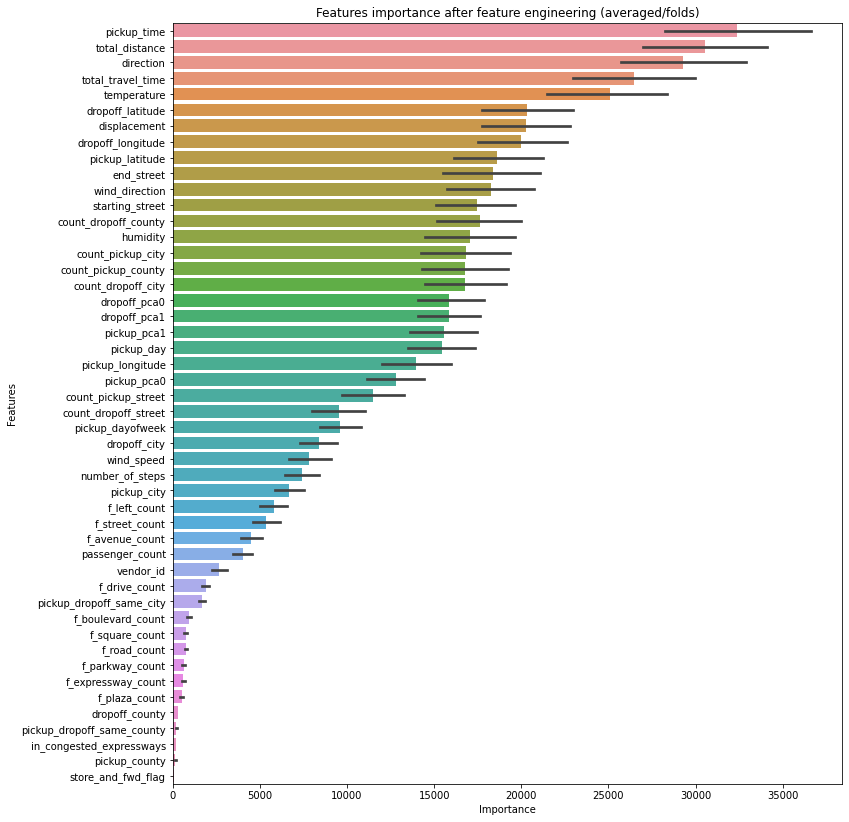

In [8]:
print("\n--------------------------------------\n LGBM results After Feature Engineering\n--------------------------------------")
print(f"Overall RMSE out-of-folds: {np.sqrt(mse(target, oof))}")

cols = (feature_importance_df[["Features", "Importance"]]
        .groupby("Features").mean().sort_values(by="Importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df['Features'].isin(cols)]

plt.figure(figsize=(12,14))
sns.barplot(x="Importance", y="Features", data=best_features.sort_values(by="Importance",ascending=False))
plt.title('Features importance after feature engineering (averaged/folds)')
plt.show()

### Submission

In [9]:
submission = pd.read_csv('/kaggle/input/nyc-taxi-trip-duration/sample_submission.zip', compression='zip') 
submission['trip_duration'] = test_pred
submission[['id', 'trip_duration']].to_csv('./submission.csv', index = False)